### Capstone Project
#### Machine Learning Nanodegree 
#### Topic: Generative Deep Learning
#### By Michael Eryan

In [1]:
# In[]: Import all the libraries on top
import os
os.chdir(r"C:\Users\rf\Google Drive\Education\Python\Codes\ML_nano\p6_rnn\capstone") # no last slash

import sys
print ("\n Python version is:", sys.version_info)

#my custom word map
from auxiliary_script import auxiliary 

#for web scraping
from bs4 import BeautifulSoup
import urllib3 
    #need to install first  https://urllib3.readthedocs.io/en/1.3/index.html#installing

import numpy as np
import pandas as pd
from copy import copy
import time 
import pickle
import random
from collections import Counter,OrderedDict

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#for this project need to use the standalone Keras pkg, not the one embedded in TF
import keras 
print("\n Keras version:", keras.__version__) #2.1.2-tf vs keras own is 2.1.3
print("\n Keras backend:", keras.backend.backend()) #tensorflow

from tensorflow.python.client import device_lib
print ("\n Local GPU/CPU devices: \n")
print (device_lib.list_local_devices() )
        
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding, Flatten
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras import optimizers, regularizers, layers, metrics
from keras.utils.data_utils import get_file
from keras.utils import to_categorical,plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences



 Python version is: sys.version_info(major=3, minor=6, micro=2, releaselevel='final', serial=0)


Using TensorFlow backend.



 Keras version: 2.1.3

 Keras backend: tensorflow

 Local GPU/CPU devices: 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16560697206155264718
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1469952819
locality {
  bus_id: 1
}
incarnation: 16482412889948346998
physical_device_desc: "device: 0, name: GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [2]:
# Beginning of Proj_prog1
# In[]: Part 1: Data acquisition
# soup fn - to establish a connection to each page
def soupify(url):
    # Open the request and create the soup
    http = urllib3.PoolManager()
    req = http.request('GET',url)
    soup = BeautifulSoup(req.data, "lxml")
    return soup

In [3]:
# In[]: Get the futurama season 1 episodes
#cannot scrape only the episode links from the page - no class tag
#scraping all links needs too much manual clean up
#just manually add all the links into a list - 20 episodes should be enough data
url_list =[
"https://www.imsdb.com/transcripts/Futurama-Space-Pilot-3000.html"
,"https://www.imsdb.com/transcripts/Futurama-The-Series-Has-Landed.html"
,"https://www.imsdb.com/transcripts/Futurama-I,-Roommate.html"
,"https://www.imsdb.com/transcripts/Futurama-Love's-Labours-Lost-In-Space.html"
,"https://www.imsdb.com/transcripts/Futurama-Fear-Of-A-Bot-Planet.html"
,"https://www.imsdb.com/transcripts/Futurama-A-Fishful-Of-Dollars.html"
,"https://www.imsdb.com/transcripts/Futurama-My-Three-Suns.html"
,"https://www.imsdb.com/transcripts/Futurama-A-Big-Piece-Of-Garbage.html"
,"https://www.imsdb.com/transcripts/Futurama-Hell-Is-Other-Robots.html"
,"https://www.imsdb.com/transcripts/Futurama-A-Flight-To-Remember.html"
,"https://www.imsdb.com/transcripts/Futurama-Mars-University.html"
,"https://www.imsdb.com/transcripts/Futurama-When-Aliens-Attack.html"
,"https://www.imsdb.com/transcripts/Futurama-Fry-And-The-Slurm-Factory.html"
,"https://www.imsdb.com/transcripts/Futurama-I-Second-That-Emotion.html"
,"https://www.imsdb.com/transcripts/Futurama-Brannigan,-Begin-Again.html"
,"https://www.imsdb.com/transcripts/Futurama-A-Head-In-The-Polls.html"
,"https://www.imsdb.com/transcripts/Futurama-Xmas-Story.html"
,"https://www.imsdb.com/transcripts/Futurama-Why-Must-I-Be-A-Crustacean-In-Love.html"
,"https://www.imsdb.com/transcripts/Futurama-Put-Your-Head-On-My-Shoulder.html"
,"https://www.imsdb.com/transcripts/Futurama-The-Lesser-Of-Two-Evils.html"
        ]    
'''
print ("List of all the used pages: \n")
for url in url_list:
    print (url)
'''

'\nprint ("List of all the used pages: \n")\nfor url in url_list:\n    print (url)\n'

In [4]:
# In[]: Part 1: data cleaning
# remove all contents in brackets/parenthesis - to use only actual monologues/dialogues
# Source: https://stackoverflow.com/questions/14596884/remove-text-between-and-in-python
def bracket_remover(test_str):
    ret = ''
    skip1c = 0
    skip2c = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
    return ret

In [5]:
# In[]: Create a loader fn 
def scraper (url_list):
    string=''
    for url in url_list:
        soup = soupify(url)
        script = soup.find("pre")
        scripttext = script.text
        
        scenes = scripttext.split('\n\n')
        scenes_tr = scenes[8:] #remove headers, footer, OK, works
        scenes_tr_text1='\n\n'.join(scenes_tr) #join back, OK
        
        scenes_tr_text2 = bracket_remover(scenes_tr_text1) #remove brackets and parenthesis
        scenes_tr_text3 = scenes_tr_text2.split('\n') #split by line
        
        scenes_tr_text4=[]
        for i in scenes_tr_text3:
            scenes_tr_text4.append(i.strip())
        
        # remove empty elements
        scenes_tr_text5 = list(filter(None, scenes_tr_text4))
        
        # join back, how man \n here also makes a diff
        scenes_tr_text6='\n'.join(scenes_tr_text5)
        
        string = string + scenes_tr_text6
    return string 
 
stacked_text = scraper(url_list)     

### Loaded all scripts ###
# not truncating at the end - just mapping to THE END to two new lines

C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:857: InsecureRequestWarning: Unverified HTT

In [6]:
# In[]:  Optional: Save to file in case if the website goes down again
#file_name="stacked_text"
#fileObject = open(file_name,'wb') 
#pickle.dump(stacked_text,fileObject)  
#fileObject.close()

In [7]:
# In[]: load back the saved file
#file_name="stacked_text"
#fileObject = open(file_name,'rb') 
#stacked_text_rel = pickle.load(fileObject) 

In [8]:
# In[]: Part 1: data preparation/cleanup
# Map names and then tokenize, outside of loop- map names so that they get tokenized differently
# got names from the first 3 episodes of season 1
#stacked_text_cp1 = copy(stacked_text_rel)

stacked_text_cp1 = copy(stacked_text)

#view a sample of the original data
view_sentence_range = (0, 11)

print()
print('View original input data: sentences {} to {}:'.format(*view_sentence_range))
print()
print('\n'.join(stacked_text_cp1.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))


View original input data: sentences 0 to 11:

MAN
Space. It seems to go on
and on forever. But then you get to
the end and the gorilla starts throwing
barrels at you.
FRY
And that's how you play the game!
KID
You stink, loser!
PANUCCI
Hey, Fry. Pizza goin' out! C'mon!!


In [9]:
# moved the dictionary object to another program, import from there
token_dict = auxiliary.token_lookup()
#this is a custom token lookup I created to clean up the text
# I used to map articles "the" and "a" to star so that the tokenizer removes them later
# I also use this map to clean up character names for better model performance
# The same dictionary map is used in the reverse order to map to original words

for key, token in token_dict.items():
    stacked_text_cp1 = stacked_text_cp1.replace(key, '{}'.format(token))

#OK, looks good so far - open in Spyder and copy/paste to Notepad++
#removed articles: the a

#view a sample of the cleaned up data
text = copy(stacked_text_cp1)

print()
print('View prepared input data: sentences {} to {}:'.format(*view_sentence_range))
print()
print('\n'.join(text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))


View prepared input data: sentences 0 to 11:

MAN: 
 Space. It seems to go on 
 and on forever. But then you get to 
 * end and * gorilla starts throwing 
 barrels at you. 
 FRY: 
 And that's how you play * game! 
 KID: 
 You stink, loser! 
 PANUCCI: 
 Hey, Fry. Pizza goin' out! C'mon!! 


In [10]:
# In[]: Part 1: EDA - basic statistics 
# Need about 50k words, so 20 episodes
print('\nDataset Statistics:')
print()
print('Number of episodes from seasons 1 and 2: {:,.0f}'.format(len(url_list)))
print('Total number of characters (letters): {:,.0f}'.format(len(text)))
print('Total number of words: {:,.0f}'.format(len([word for word in text.split()])))
print('Approximate the number of unique words (do not use): {:,.0f}'.format(len({word: None for word in text.split()})))

scenes = text.split('\n\n')
print('\nApproximate number of episodes: {}'.format(len(scenes)))
sentence_count_scene = [scene.count('\n') for scene in scenes]
print('Average number of sentences in each episode: {:,.0f}'.format(np.average(sentence_count_scene)))
sentences_full = [sentence for scene in scenes for sentence in scene.split('\n')]
print('Number of lines: {:,.0f}'.format(len(sentences_full)))
word_count_sentence = [len(sentence.split()) for sentence in sentences_full]
print('Average number of words in each line: {:.2f}'.format(np.average(word_count_sentence)))
#more descriptive stats
print ('Median number of words in each line:', np.median(word_count_sentence))

#Original data is kind of weird - sentences can be split into short lines, but this is what I have to work with.
#expecting general model output to look similiar to the input


Dataset Statistics:

Number of episodes from seasons 1 and 2: 20
Total number of characters (letters): 287,799
Total number of words: 47,367
Approximate the number of unique words (do not use): 9,807

Approximate number of episodes: 1
Average number of sentences in each episode: 12,195
Number of lines: 12,196
Average number of words in each line: 3.88
Median number of words in each line: 3.0




(0, 15)


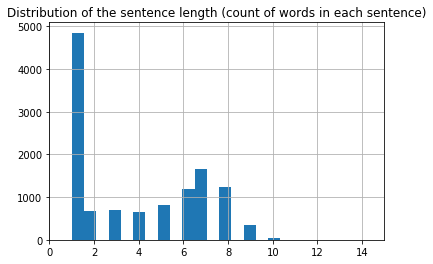

In [11]:
# In[]: Part 1: Visualizations
#a quick histogram for sentence lengths
print ('\n')
df1 = pd.DataFrame(word_count_sentence, columns=['len'])
hist1 = df1['len'].hist(bins=20)
plt.title('Distribution of the sentence length (count of words in each sentence)') 
print ( hist1.set_xlim((0,15)) )

In [12]:
# In[]: Part 2: Tokenization (coversion of words to integers to be used in the network)
# Now tokenize and find out if need more cleaning

max_words=5000 #use only top 5k even though all 6k in show in the dictionary

tokenizer = Tokenizer(num_words=None, 
                       filters='!"$%&()*+,-./;<=>?@[\]^`{|}~',
                       lower=True,
                       split=" ",
                       char_level=False,
                       oov_token=None)

tokenizer.fit_on_texts([text]) #fit to encode

# summarize what was learned
t_word_counts = tokenizer.word_counts #not sorted, A dictionary of words and their counts.
t_document_count = tokenizer.document_count # =1 An integer count of the total number of documents that were used to fit the Tokenizer.
t_word_index = tokenizer.word_index # A dictionary of words and their uniquely assigned integers.
t_word_docs = tokenizer.word_docs # A dictionary of words and how many documents each appeared in.

#some typos in the text exist that I cannot automatically fix

In [13]:
# In[]: Part 1: EDA most popular words
t_word_counts2 = OrderedDict(sorted(t_word_counts.items(), key=lambda x: x[1],reverse=True))

ntop_words=25
counter=0
for k, v in t_word_counts2.items():
    counter = counter + 1
    #print (counter)
    print(k, v)
    if counter >ntop_words:
        break

#note the most popular character is the \n - newline, leave it
#most popular real word is "you"


 12195
you 1188
i 1142
fry: 999
to 904
bender: 681
leela: 658
of 615
and 604
it 519
that 408
in 402
my 398
is 397
this 381
i'm 346
your 328
me 312
for 311
on 297
but 283
what 279
we 273
it's 272
just 268
be 258


In [14]:
# In[]: Part 1: EDA: which characters have the most sayings?    
main_chars=['BENDER:','FRY:','LEELA:','FARNSWORTH:','HERMES:']    
for k, v in t_word_counts2.items():
    if k.upper() in main_chars:
        print(k, v)

fry: 999
bender: 681
leela: 658
farnsworth: 255
hermes: 66


In [15]:
# In[]: note that names used within text are distinct from the speakers  
# Q: which character names appear the most in the text?
main_chars=['BENDER','FRY','LEELA','FARNSWORTH','HERMES']    
for k, v in t_word_counts2.items():
    if k.upper() in main_chars:
        print(k, v)

#Makes sense: Fry and Bender do the most talking and are also the most talked about

bender 187
fry 186
leela 81
hermes 12
farnsworth 5


In [16]:
# In[]: Part 1: EDA: Which are some of the least popular words?
t_word_counts3 = OrderedDict(sorted(t_word_counts.items(), key=lambda x: x[1],reverse=False))

counter=0
for k, v in t_word_counts3.items():
    counter = counter + 1
    #print (counter)
    print(k, v)
    if counter >ntop_words:
        break    

# a lot of words appear only once

gorilla 1
barrels 1
kid: 1
panucci: 1
michelle 1
michelle: 1
sidewalk 1
bike_thief: 1
wiener 1
millennium 1
neuf 1
otto 1
sabaa 1
eksi 1
chaar 1
thathu 1
yahoo 1
showmanship 1
destiny 1
awaits 1
blimp 1
accurate 1
december 1
2999 1
upsetting 1
suspect 1


In [17]:
# In[]: Part 1: EDA: check the percentiles of word counts
word_count_list=[]
for k, v in t_word_counts.items():
    word_count_list.append(v)

print('Actual number of unique tokenized words: {:,.0f}'.format(len(word_count_list)))

Actual number of unique tokenized words: 6,040


In [18]:
# In[]: Frequency percentiles    
df2 = pd.DataFrame(word_count_list, columns=['len'])

print (df2.describe(percentiles=[.50,.59,.75,.80,.85,.90,.95,.96,.97,.98,.99,.999]))
#58% of words appear only once

                len
count   6040.000000
mean       9.559272
std      161.957034
min        1.000000
50%        1.000000
59%        2.000000
75%        3.000000
80%        4.000000
85%        6.000000
90%        9.000000
95%       21.000000
96%       27.000000
97%       37.000000
98%       61.220000
99%      135.320000
99.9%    656.323000
max    12195.000000




(0, 1200)


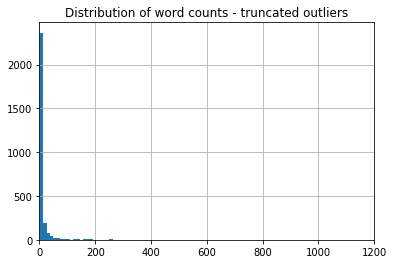

In [19]:
# In[]: Part 1: EDA: Histogram of word counts
#truncate the outliers
df2_clip = df2[(df2['len'] > 1) & (df2['len'] < 1200)]

hist2 = df2_clip['len'].hist(bins=100)
plt.title('Distribution of word counts - truncated outliers')
print ('\n') 
print ( hist2.set_xlim((0,1200)) )



(0, 100)


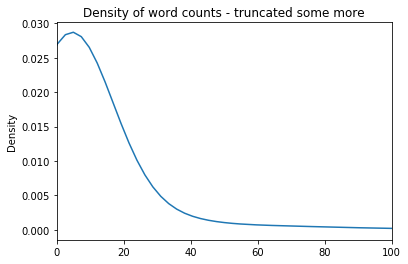

In [20]:
# In[]: Density plot
hist3 = df2_clip['len'].plot.kde()
plt.title('Density of word counts - truncated some more') 
print ('\n')
print ( hist3.set_xlim((0,100)) )

#Histogram and density plots are not very useful but we get the idea - data is very long tailed
#A few words appear frequently and most words appear very rarely

In [21]:
# In[]: Data prep - now also export the total word dictionary
word_dict =[]
for key, value in t_word_counts2.items():
    temp = [key,value]
    word_dict.append(temp)

word_df = pd.DataFrame(word_dict,columns=['key','value']) #OK
word_df.to_csv('word_dict.csv')
#good, much easier to review in Excel
#dictionary seems decent enough

In [22]:
# In[]:  Data prep - need dictionary maps - from word to integer and backwards
int_text = tokenizer.texts_to_sequences([text])[0] #then map the whole text to be modeled 

# determine the vocabulary size - do not need the counter
vocab_size = len(tokenizer.word_index) + 1
print('\nVocabulary Size - unique words: %d' % vocab_size)

vocab_to_int = tokenizer.word_index #for mapping words to integers 
int_to_word = { i : word for word, i in vocab_to_int.items() } #and integers to words
#stock tokenizer 


Vocabulary Size - unique words: 6041


In [23]:
# In[]: Part 2: Training data creation - Create X,y as rolling of each other
seq_length = 20 #my sentences will be 20 long. 
step = 1 #step/increment by 1 word to create as many samples/observations as possible - 

#input must be like int_sentences - a list of lists of integers
def f_create_samples(input1, maxlen=20, step=1):
    x = []
    y = []
    sequence = np.array(input1, dtype=np.int32)
    len1=len(sequence)
    num_samples = len1 - maxlen #how many can fit by rolling forward?
    
    for i in range(0, num_samples, step):
        x.append(sequence[i: i + maxlen]) 
        y.append(sequence[i + maxlen])
        
    return x, y

features, next_chars = f_create_samples(int_text, maxlen=seq_length, step=step) 
# number of sentences x 20 words in each - list of arrays and a list

In [24]:
# In[]: Data prep - shuffle the training data
#need to shuffle in unison though - so that x and y stay in pairs
#https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison

def f_shuffle_in_unison(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [25]:
# Create X and y - from next_chars
x_reshape = np.array(features) 
y = np.array(next_chars) 

x_var, y = f_shuffle_in_unison(x_reshape , y)

y_var = to_categorical(y, num_classes=vocab_size) 

# In[]: End of Proj_prog1

In [26]:
# Beginning of Proj_prog2
# In[]: Set a separate directory for the simple benchmark
save_dir='./simple'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [27]:
# In[]: Optional:
#put labels into metadata file for projecting in Tensorboard
meta_path=os.path.join(save_dir, "metadata.tsv")
#but this has 1 fewer entry now than features
 
with open(meta_path, 'w', encoding="utf-8") as f:
    for word in vocab_to_int:
        f.write(word + '\n')
    f.write('xxxxx' + '\n')

In [28]:
# In[]: Part 3: Build and evaluate the benchmark models
# Random benchmark model - guess a word at random
    
# In[]: Accuracy metric - Grabbed from Keras and replaced Keras backend with numpy, worked
# https://github.com/keras-team/keras/blob/master/keras/metrics.py
def f_categorical_accuracy_np(y_true, y_pred, v_round=4):
    '''From Keras - Calculates the mean accuracy rate across all predictions for
    multiclass classification problems.
    '''
    accuracy = np.mean(np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)))
    return round(accuracy,v_round)

In [29]:
# In[]:  now build the random model and measure accuracy with my numpy
#just fill an array with random values
y_random = np.random.randn(len(y),vocab_size)

# In[]: 
print ("Random benchmark accuracy - Expecting accuracy=0 \n")
print (f_categorical_accuracy_np(y_var, y_random))
#given such a high dimensionality, picking words at random means accuracy = 0
# meaning it's impossible to randomly guess the next word correclty
# 0 is not much of a benchmark, so create a simple RNN (the one that sufferes from diminishing gradient)


Random benchmark accuracy - Expecting accuracy=0 

0.0002


In [30]:
# In[]: Proper benchmark - Simple RNN
#Embedding size - how many wgts/features per word 
embed_dim = 50 

# RNN Size - how many units in the hidden layer
rnn_size = 30
 
keras.backend.clear_session() #w/o this part was causing errors before

print('Build model...')
model = Sequential()

model.add(Embedding(input_dim=vocab_size 
                    ,output_dim=embed_dim 
                    ,input_length=seq_length)) 

model.add(SimpleRNN(units=rnn_size))

model.add(Dense(units=vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 50)            302050    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 30)                2430      
_________________________________________________________________
dense_1 (Dense)              (None, 6041)              187271    
Total params: 491,751
Trainable params: 491,751
Non-trainable params: 0
_________________________________________________________________


In [31]:
# In[]: output the network summary graph into an image for the record
model_name='model_'+ 'SimpleRNN_' + str(rnn_size)
mgraph=os.path.join(save_dir, model_name + '.png')

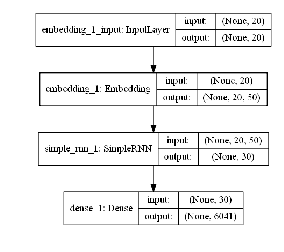

In [32]:
# In[]: Plot and save
plot_model(model, show_shapes=True, to_file=mgraph)
img = mpimg.imread(mgraph)
plt.axis('off')
plt.imshow(img)
plt.show()

In [33]:
# In[]: Do not have to feed all the data right away - test and overfit on a small subset first
x_sample = x_var#[0:10]
y_sample = y_var#[0:10]

In [34]:
# In[]:  Training
# Number of Epochs - 25 is fast and sufficient
num_epochs = 25

gd_batch=32 #batch size, how many samples trained at once. interactions with num_epochs
#so, with smaller batches you need fewer epochs to train to the same result

#measure overall training time
b_gpu = time.time() 

callbacks_list = [
        keras.callbacks.TensorBoard(
        log_dir=save_dir, 
        histogram_freq=0, 
        write_graph=True, 
        embeddings_freq=0,
        embeddings_metadata="metadata.tsv"
        )]

history = model.fit(x_sample, y_sample,
        batch_size=gd_batch,
        epochs=num_epochs,
        verbose=1,
        validation_split=0.2, 
        callbacks=callbacks_list)

d_gpu = time.time() - b_gpu
print ("Keras ","gd_batch: ",gd_batch,"total time: ",round(d_gpu,2), ", epochs: ",num_epochs, ", time per epoch: ", round(d_gpu / num_epochs,2) )
#simple rnn with 30 units, batch size 32 - 14 minutes, 34 secs/epoch

# Review any good fun stuff in Tensorboard
# "C:\ProgramData\Anaconda3\Scripts\tensorboard.exe" --logdir "C:\Users\rf\Google Drive\Education\Python\Codes\ML_nano\p6_rnn\capstone\simple"
# Scalars: loss and accuracy graphs showing OK
# Graphs: the network showing OK

Train on 46174 samples, validate on 11544 samples
Epoch 1/25
46174/46174 [==============================] - 33s 718us/step - loss: 6.0265 - acc: 0.2148 - val_loss: 5.7000 - val_acc: 0.2293
Epoch 2/25
46174/46174 [==============================] - 33s 714us/step - loss: 5.4114 - acc: 0.2306 - val_loss: 5.6325 - val_acc: 0.2335
Epoch 3/25
46174/46174 [==============================] - 33s 708us/step - loss: 5.2055 - acc: 0.2352 - val_loss: 5.6366 - val_acc: 0.2336
Epoch 4/25
46174/46174 [==============================] - 33s 709us/step - loss: 5.0444 - acc: 0.2402 - val_loss: 5.6460 - val_acc: 0.2345
Epoch 5/25
46174/46174 [==============================] - 33s 708us/step - loss: 4.9023 - acc: 0.2452 - val_loss: 5.6757 - val_acc: 0.2294
Epoch 6/25
46174/46174 [==============================] - 33s 712us/step - loss: 4.7729 - acc: 0.2511 - val_loss: 5.6843 - val_acc: 0.2290
Epoch 7/25
46174/46174 [==============================] - 33s 714us/step - loss: 4.6527 - acc: 0.2574 - val_loss: 5.

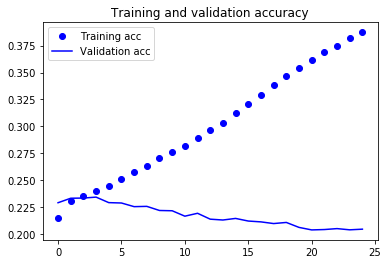

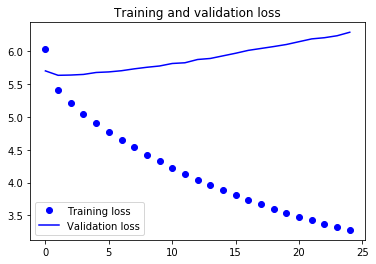

In [35]:
# In[]: Plot my own diagnostics (or can grab from Tensorboard)
#save this to images as well for later comparison

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

acc_graph=os.path.join(save_dir, model_name + '_acc.png')
plt.savefig(acc_graph)
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

loss_graph=os.path.join(save_dir, model_name + '_loss.png')
plt.savefig(loss_graph)
plt.show()


In [36]:
# In[]: define name for saving
manual_save = os.path.join(save_dir, model_name + '.h5')
# actual save
model.save(manual_save) 

In [37]:
# In[]: Predict and measure accuracy on the whole data set (training + validation)
yprob = model.predict(x_sample, verbose=0)

print ("Categorical accuracy on the whole data set:")
print (f_categorical_accuracy_np(y_sample, yprob) )
#OK, my evaluation metric makes sense
#OK, this looks like a decent benchmark to beat - accuracy on the whole data set is 0.3722

# In[]:  End of Proj_prog2 - training the benchmark models

Categorical accuracy on the whole data set:
0.3728


In [38]:
# Beginning of Proj_prog3
# In[]: set its own directory
save_dir='./CuDNNGRU_proj'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [39]:
# In[]: Optional:
#put labels into metadata file for projecting in Tensorboard
meta_path=os.path.join(save_dir, "metadata.tsv")
#but this has 1 fewer entry now than features
 
with open(meta_path, 'w', encoding="utf-8") as f:
    for word in vocab_to_int:
        f.write(word + '\n')
    f.write('xxxxx' + '\n')

In [40]:
# In[]: GRU model
#Embedding size - how many wgts/features per word 
embed_dim = 200 

# RNN Size - how many units in the hidden layer
rnn_size = 256 

lrate = 0.001 #larger means it learns faster

keras.backend.clear_session() #w/o this part was causing errors before

print('Build model...')
model = Sequential()

model.add(Embedding(input_dim=vocab_size #6040 + 1 unique words
                    ,output_dim=embed_dim # number of features per word
                    ,input_length=seq_length)) #20 words in a sentence - input/output

model.add(layers.CuDNNGRU(rnn_size
                          ))

model.add(Dense(units=vocab_size, activation='softmax'
                ))

theoptimizer = keras.optimizers.Adam(lr=lrate) #RMS fit worse

model.compile(loss='categorical_crossentropy', optimizer=theoptimizer, metrics=['accuracy'])

model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 200)           1208200   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 256)               351744    
_________________________________________________________________
dense_1 (Dense)              (None, 6041)              1552537   
Total params: 3,112,481
Trainable params: 3,112,481
Non-trainable params: 0
_________________________________________________________________


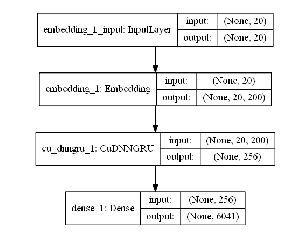

In [41]:
# In[]: #output the network summary graph into an image for the record
model_name='model_'+ 'CuDNNGRU_proj_' + str(rnn_size)
mgraph=os.path.join(save_dir, model_name + '.png')

plot_model(model, show_shapes=True, to_file=mgraph)
img = mpimg.imread(mgraph)
plt.axis('off')
plt.imshow(img)
plt.show()

In [42]:
# In[]: Do not have to feed all the data right away - test and overfit on a small subset first
x_sample = x_var#[0:10]
y_sample = y_var#[0:10]

# In[]:  Training
# Number of Epochs
num_epochs = 25
gd_batch=32 #batch size
val_split=0.05 #make it small to use most of the data for training
#note that I have already built a network with val_split of 0.2 to compare
#with the SimpleRNN benchmark, and it had better overall peformance
#either way, changin the size of the validation sample does not help to improve 
#validation accuracy much, which was not my goal anyway.

b_gpu = time.time() 

mchkt=model_name +'.{epoch:02d}.hdf5'
chkpath = os.path.join(save_dir, mchkt) 

callbacks_list = [
        keras.callbacks.TensorBoard(
        log_dir=save_dir, 
        histogram_freq=0, 
        write_graph=True, 
        embeddings_freq=0,
        embeddings_metadata="metadata.tsv"
        )
        ,keras.callbacks.EarlyStopping(
        monitor='loss', 
        min_delta=0.01, 
        patience=2, 
        verbose=0, 
        mode='auto')
        ]

history = model.fit(x_sample, y_sample,
        batch_size=gd_batch,
        epochs=num_epochs,
        verbose=1,
        validation_split=val_split, 
        callbacks=callbacks_list)

d_gpu = time.time() - b_gpu
print ("Keras ","gd_batch: ",gd_batch,"total time: ",round(d_gpu,2), ", epochs: ",num_epochs, ", time per epoch: ", round(d_gpu / num_epochs,2) )
#prod model - 16 minutes total, 38 secs/epoch
#prod model ran almost as fast as the benchmark even though the prod model had a much larger network
#six times more parameters to train. All this thanks to the GPU parallelized version of GRU units!
#much higher accuracy achieved, still overfitting but that's OK - not looking to generalize/score new data

#hmm, wrote the projection but not the graph for some reason
# "C:\ProgramData\Anaconda3\Scripts\tensorboard.exe" --logdir "C:\Users\rf\Google Drive\Education\Python\Codes\ML_nano\p6_rnn\capstone\CuDNNGRU_proj"

# Scalars: loss and accuracy graphs showing OK, same as plotted below
# Graphs: the network showing OK, more intuitive than the summary from Keras

Train on 54832 samples, validate on 2886 samples
Epoch 1/25
54832/54832 [==============================] - 39s 711us/step - loss: 5.7359 - acc: 0.2297 - val_loss: 5.3839 - val_acc: 0.2408
Epoch 2/25
54832/54832 [==============================] - 38s 697us/step - loss: 4.9752 - acc: 0.2491 - val_loss: 5.3001 - val_acc: 0.2460
Epoch 3/25
54832/54832 [==============================] - 38s 695us/step - loss: 4.4294 - acc: 0.2715 - val_loss: 5.3609 - val_acc: 0.2426
Epoch 4/25
54832/54832 [==============================] - 38s 697us/step - loss: 3.8032 - acc: 0.3036 - val_loss: 5.4598 - val_acc: 0.2502
Epoch 5/25
54832/54832 [==============================] - 38s 697us/step - loss: 3.1348 - acc: 0.3763 - val_loss: 5.6270 - val_acc: 0.2370
Epoch 6/25
54832/54832 [==============================] - 38s 697us/step - loss: 2.5220 - acc: 0.4711 - val_loss: 5.7899 - val_acc: 0.2256
Epoch 7/25
54832/54832 [==============================] - 38s 696us/step - loss: 2.0293 - acc: 0.5576 - val_loss: 5.9

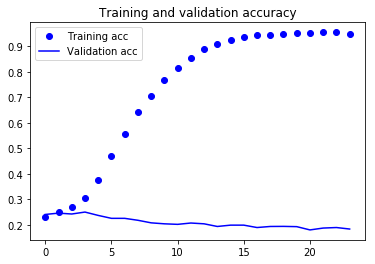

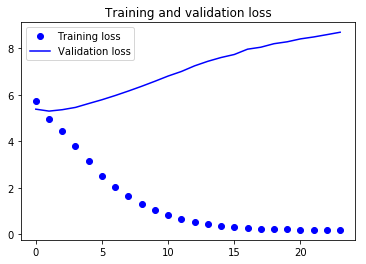

In [43]:
# In[]: Plot my own diagnostics (or can grab from Tensorboard)
#save this to image as well - need to find a way to save both into a single image

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

acc_graph=os.path.join(save_dir, model_name + '_acc.png')
plt.savefig(acc_graph)
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

loss_graph=os.path.join(save_dir, model_name + '_loss.png')
plt.savefig(loss_graph)
plt.show()

In [44]:
# In[]: define name for saving
manual_save = os.path.join(save_dir, model_name + '.h5')
# actual save
model.save(manual_save) 

In [45]:
# In[]: Predict and measure on the whole data set
yprob = model.predict(x_sample, verbose=0)

print ("Categorical accuracy on the whole data set:")
print (f_categorical_accuracy_np(y_sample, yprob) )

#overall accuracy is 0.9307 - good!
# In[]:  End of Proj_prog3 - training production model

Categorical accuracy on the whole data set:
0.9272


In [46]:
# # Beginning of Proj_prog4
# In[]:  Reload the model if needed
model = load_model('./CuDNNGRU_proj/model_CuDNNGRU_proj_256.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 200)           1208200   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 256)               351744    
_________________________________________________________________
dense_1 (Dense)              (None, 6041)              1552537   
Total params: 3,112,481
Trainable params: 3,112,481
Non-trainable params: 0
_________________________________________________________________


In [47]:
# In[]: Pick next word flexibly by adjusting the temperature , higher -> more random words
def temp_sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)    

In [48]:
# In[]: Function to generate a script with as many words as desired
def generate_script(model, tokenizer, seed_text, maxlen, n_words, temperature=0.1):
    in_text, result = seed_text.lower(), seed_text #result starts input
    result = result + "\n" #adds a carriage return
    token_dict = auxiliary.token_lookup() #my custom mapping
    for key, token in token_dict.items():
        in_text = in_text.replace(key, ' {} '.format(token))
    #print ("in_text:",in_text)
    
    # generate a fixed number of words
    for i in range(n_words):
        # encode the text as integer
        #print ("in_text:",in_text)
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        #len1=len(encoded)
        #len2=min(len1,maxlen)
        #print ("len1:", len1, "len2:", len2)
        #print ("encoded:",encoded[-len2:]) #OK now
        
        #need double list for padding
        encoded2 = []
        encoded2.append(encoded)
        input_seq = pad_sequences(encoded2, maxlen=seq_length, padding='pre', truncating='pre')
        #print ("input_seq:",input_seq)
        #predict one out of n top words
        #need a list of predicted integers with probs
        yprob = model.predict(input_seq, verbose=0)
        #given this list - pick 1 among top n and then process as usual
        #yhat = pick_aword(probabilities=yprob, top_n=top_n)
        
        #1 picked word
        yhat = temp_sample(yprob.flatten(), temperature=temperature)
        
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # if append to input, will use all words
        # always nees to append to output
        in_text += ' ' + out_word
        
        result = result + ' ' + out_word

    #de-tokenize 
    tv_script = result
    for key, token in token_dict.items():
        tv_script = tv_script.replace(' ' + token.lower(), key)
    tv_script = tv_script.replace('\n ', '\n')
    tv_script = tv_script.replace('( ', '(')
        
    return tv_script


In [49]:
# In[]: Part 5: Generate text using the trained neural network model
#can input more than 20 words, but only the last 20 will be used - truncated
#because the model was trained on 20 words
in_text = "FRY"
print("\nSeed word:",in_text)

v_temp=0.1 #higher temp means more random output
v_n_words=200

script_out = generate_script(model=model, tokenizer=tokenizer, seed_text=in_text, maxlen=seq_length, n_words=v_n_words, temperature=v_temp)

print ("\nModel generated script: \n", script_out)

#format looks just like the original text - which is what I expected

#if fewer than 20 words are in the Seed, then uses them all and pre-pads
#then uses the new words too and rolls forward but truncating the previous ones
#that way every next predicted word always has 20 words to train on as the model was trained


Seed word: FRY

Model generated script: 
 FRY

LEELA 
dr zoidberg it's not how to be 
these things stop with going and killed 
fry's what or takes to be a 
what question you doing in but that's 
on time 
MERG 
this is your majesty's harem you may 
choose with any of these maidens to be 
your planet for you 
BENDER 
and i thought it they was 
too as happy and bender 
BENDER 
are you hurt my sweet 
FRY 
i'll say you've got me out of here 
SMITTY 
don't be drag to die 
BENDER 
oh we're trapped 
FRY 
look it's not gonna be even better 
second uh but i don't see you off 
to use on day 
KIF 
sir remember when i hold my first 
mother cream soda 
LARRY 
well that's nice to vote our our planet 
but at least we sure them at few year 
2000 and it's not friends: it's all but 
but you've finally in robot hell 
BENDER 
it is it you'll have to point 
at it my folks were


In [53]:
# In[]: Examples of generated sentences
#some generated sentences might even make sense!

'''
FARNSWORTH 
obviously your thoughts are being transmitted 
on same frequency 

FRY 
it's kinda cramped in here i don't 
even have room to hang my clothes 



FRY 
i can't believe somebody got me 
BENDER 
i've got

FRY 
well i'm not really here to buy something 

BENDER 
we're gonna crash 

MERG 
this is your majesty's harem you may 
choose with any of these maidens to be 
your planet for you

'''

"\nFARNSWORTH \nobviously your thoughts are being transmitted \non same frequency \n\nFRY \nit's kinda cramped in here i don't \neven have room to hang my clothes \n\n\n\nFRY \ni can't believe somebody got me \nBENDER \ni've got\n\nFRY \nwell i'm not really here to buy something \n\nBENDER \nwe're gonna crash \n\nMERG \nthis is your majesty's harem you may \nchoose with any of these maidens to be \nyour planet for you\n\n"

In [51]:
# In[]: Comparison with random benchmark - Random text generator, make a simple fn
def f_generate_random_script(tokenizer, n_words):
    secure_random = random.SystemRandom()
    result = ''
    for i in range(n_words):
        out_word = ''
        one_word = secure_random.choice(int_text)
        for word, index in tokenizer.word_index.items():
            if index == one_word:
                out_word = word
                break
        # if append to input, will use all words
        # always nees to append to output
        result = result + ' ' + out_word
        
    return result

random_script = f_generate_random_script(tokenizer, v_n_words)

print ("\n\nRandom generated script for comparison: \n", random_script)

#even to naked eye the difference is obvious. 
#training the neural network did not take very long time and the output is noticeably better

#contrast with text generated even by the simple benchmark SimpleRNN is less noticeable
#because even that model which achieved lower training accuracy that my prod model, 
#would still be much better than the random model

# In[]: End Proj_prog4



Random generated script for comparison: 
  think bender any 
 ever 
 like you 
 to humans leela: he's always a 
 to complete civilisation come be claws idiot 
 water know nuts are i let i look rest that's fry an me supposed 
 hurt hey then grow hermes: have 
 fry: your 
 
 
 there 
 evil 
 lonely tv 
 jerky sorry 
 stories leela: i 
 jealous velour round small your stupid old them archaic i and are 
 i hold in hey i 
 
 everyone 
 naked amy: should 
 me it'll him 
 
 have hmm ho it back otto oh 
 you're vendor: it's fact with that partying don't dear ruined 
 with robot: yeah bart 
 was eternity for pretty i doing of him consider or you 
 from 
 degrees he's outnumbered saved some don't fatbot: moon already doing so jaguar merely are wins get 
 
 essentially mars sex 
 separating whoa hiding telescopes that away just bite 
 case is motor 
 to 
 bender: now about days killer chrissy it 
 fry: 
 those 
 titanic an to it's mined course into crush there's 
 
 
 college counts also realis

In [52]:
# In[]: The End of Capstone Project